In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import os



C:\Users\thava\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# -----------------------------
# Step 1: Explanatory Data Analysis and Feature Engineering
# -----------------------------
print("Step 1: Explanatory Data Analysis and Feature Engineering")

# Download required NLTK resources (only once)
nltk.download('stopwords')
nltk.download('punkt')

# Load data – adjust the file path as needed
df = pd.read_csv('complaints.csv', dtype={'Consumer disputed?': str}, low_memory=False)
print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())

# Check missing values for key columns
print("\nMissing values in [Product, Consumer complaint narrative]:")
print(df[['Product', 'Consumer complaint narrative']].isnull().sum())

# Filter relevant columns and remove rows with missing complaint narratives
df = df[['Product', 'Consumer complaint narrative']].dropna(subset=['Consumer complaint narrative'])
print("After filtering, dataset shape:", df.shape)

# Feature Engineering: Add text length feature
df['text_length'] = df['Consumer complaint narrative'].apply(len)
print("Text length feature added. Sample lengths:")
print(df['text_length'].head())



Step 1: Explanatory Data Analysis and Feature Engineering


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\thava/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\thava/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Dataset shape: (7848317, 18)
Columns: ['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue', 'Consumer complaint narrative', 'Company public response', 'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?', 'Submitted via', 'Date sent to company', 'Company response to consumer', 'Timely response?', 'Consumer disputed?', 'Complaint ID']

Missing values in [Product, Consumer complaint narrative]:
Product                               0
Consumer complaint narrative    5332868
dtype: int64
After filtering, dataset shape: (2515449, 2)
Text length feature added. Sample lengths:
9     1823
13    2807
14    1137
19    2559
20    1935
Name: text_length, dtype: int64


Category mapping completed. Category distribution:
category
0    1975472
1     304468
3     125660
2     109849
Name: count, dtype: int64


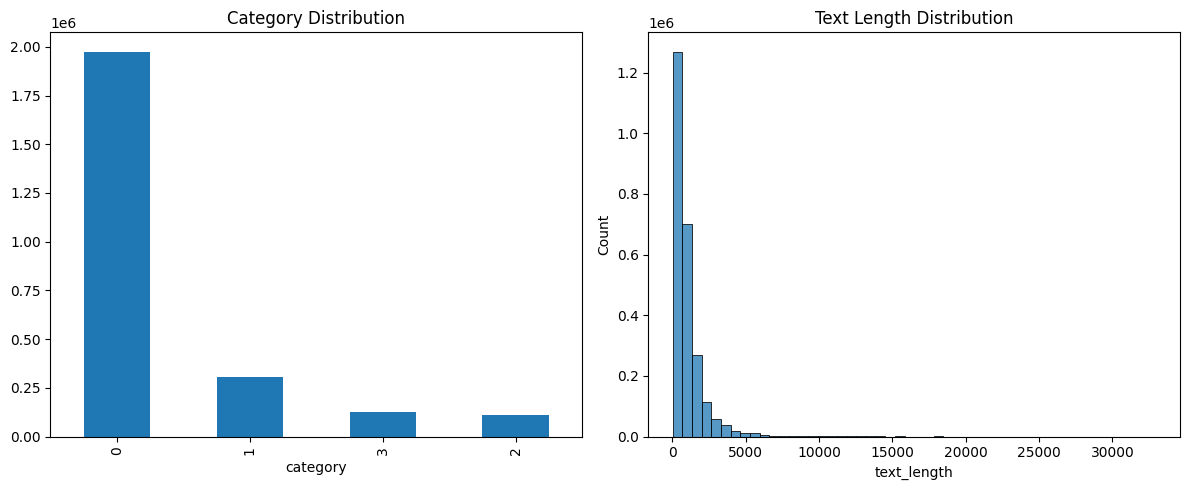

In [3]:

# Define category mapping dictionary
category_map = {
    0: ['Credit reporting', 'Credit card', 'Checking or savings account'],
    1: ['Debt collection'],
    2: ['Payday loan', 'Student loan', 'Vehicle loan'],
    3: ['Mortgage']
}

def map_category(product):
    product = str(product).lower()
    for cat, keywords in category_map.items():
        for kw in keywords:
            if kw.lower() in product:
                return cat
    return 0  # Default category if no keywords found

# Create the target variable "category"
df['category'] = df['Product'].apply(map_category)
print("Category mapping completed. Category distribution:")
print(df['category'].value_counts())

# Visualizations for EDA
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
df['category'].value_counts().plot(kind='bar')
plt.title('Category Distribution')
plt.subplot(1, 2, 2)
sns.histplot(df['text_length'], bins=50)
plt.title('Text Length Distribution')
plt.tight_layout()
plt.show()

In [4]:
# -----------------------------
# Step 2: Text Pre-Processing
# -----------------------------
print("\nStep 2: Text Pre-Processing")

# Set explicit NLTK data path (optional, if needed)
nltk_data_path = os.path.join(os.path.expanduser("~"), "nltk_data")
os.makedirs(nltk_data_path, exist_ok=True)
nltk.data.path.append(nltk_data_path)

# Download additional NLTK resources if necessary
nltk.download('wordnet', download_dir=nltk_data_path)
nltk.download('omw-1.4', download_dir=nltk_data_path)
# (Other downloads already done above)

# Check if cleaned text column exists; if not, run preprocessing
if 'clean_text' not in df.columns:
    print("Running text preprocessing...")
    stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()

    def preprocess_text(text):
        try:
            text = str(text).lower()
            text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation and numbers
            words = nltk.word_tokenize(text)
            words = [stemmer.stem(w) for w in words if w not in stop_words]
            return ' '.join(words)
        except Exception as e:
            print(f"Error processing text: {str(e)}")
            return ""
    
    tqdm.pandas(desc="Preprocessing Progress")
    df['clean_text'] = df['Consumer complaint narrative'].progress_apply(preprocess_text)
    print("Text preprocessing completed. Here are some cleaned texts:")
    print(df['clean_text'].head())
else:
    print("Clean text column already exists.")



Step 2: Text Pre-Processing


[nltk_data] Downloading package wordnet to C:\Users\thava\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\thava\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Running text preprocessing...


Preprocessing Progress: 100%|██████████| 2515449/2515449 [51:34<00:00, 812.82it/s] 

Text preprocessing completed. Here are some cleaned texts:
9     subject complaint regard inaccur late payment ...
13    subject formal complaint xxxx transunion nonco...
14    subject followup disput submit xxxxyear reques...
19    xxxxyear subject xxxx xxxx xxxx transunion xxx...
20    xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx x...
Name: clean_text, dtype: object


In [5]:
# -----------------------------
# Step 3: Selection of Multi-Classification Model
# -----------------------------
print("\nStep 3: Selection of Multi-Classification Model")
# For demonstration, we use three models: Naive Bayes, SVM, and Random Forest.
print("Selected models: Naive Bayes, Linear SVM (with balanced class weight), and Random Forest (with balanced class weight).")



Step 3: Selection of Multi-Classification Model
Selected models: Naive Bayes, Linear SVM (with balanced class weight), and Random Forest (with balanced class weight).


In [6]:
# -----------------------------
# Step 4: Comparison of Model Performance
# -----------------------------
print("\nStep 4: Comparison of Model Performance")
# Vectorization using TF-IDF
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X = tfidf.fit_transform(df['clean_text'])
# IMPORTANT: Ensure the target column exists!
if 'category' not in df.columns:
    raise KeyError("The 'category' column is missing. Please run the category mapping step first.")
y = df['category']

# Split data (80/20) with stratification to handle class imbalance
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
print("Data split into training and testing sets.")

# Initialize models
models = {
    'Naive Bayes': MultinomialNB(),
    'SVM': LinearSVC(class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1)
}

# Train each model and compare their performance
results = {}
for name, model in tqdm(models.items(), desc="Training Models"):
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    results[name] = {'accuracy': acc, 'report': report, 'model': model}
    
    print(f"{name} Performance:")
    print(f"Accuracy: {acc:.4f}")
    print(report)



Step 4: Comparison of Model Performance
Data split into training and testing sets.


Training Models:   0%|          | 0/3 [00:00<?, ?it/s]


Training Naive Bayes...


Training Models:  33%|███▎      | 1/3 [00:01<00:02,  1.10s/it]

Naive Bayes Performance:
Accuracy: 0.8751
              precision    recall  f1-score   support

           0       0.94      0.92      0.93    395094
           1       0.75      0.65      0.70     60894
           2       0.49      0.73      0.58     21970
           3       0.71      0.90      0.80     25132

    accuracy                           0.88    503090
   macro avg       0.72      0.80      0.75    503090
weighted avg       0.89      0.88      0.88    503090


Training SVM...


Training Models:  67%|██████▋   | 2/3 [19:44<11:36, 696.39s/it]

SVM Performance:
Accuracy: 0.9062
              precision    recall  f1-score   support

           0       0.96      0.93      0.95    395094
           1       0.73      0.78      0.76     60894
           2       0.61      0.81      0.69     21970
           3       0.84      0.93      0.88     25132

    accuracy                           0.91    503090
   macro avg       0.78      0.86      0.82    503090
weighted avg       0.91      0.91      0.91    503090


Training Random Forest...


Training Models: 100%|██████████| 3/3 [7:53:03<00:00, 9461.11s/it] 

Random Forest Performance:
Accuracy: 0.9281
              precision    recall  f1-score   support

           0       0.95      0.97      0.96    395094
           1       0.84      0.77      0.80     60894
           2       0.81      0.63      0.71     21970
           3       0.93      0.87      0.90     25132

    accuracy                           0.93    503090
   macro avg       0.88      0.81      0.84    503090
weighted avg       0.93      0.93      0.93    503090




Step 5: Model Evaluation
Selected best model: Random Forest


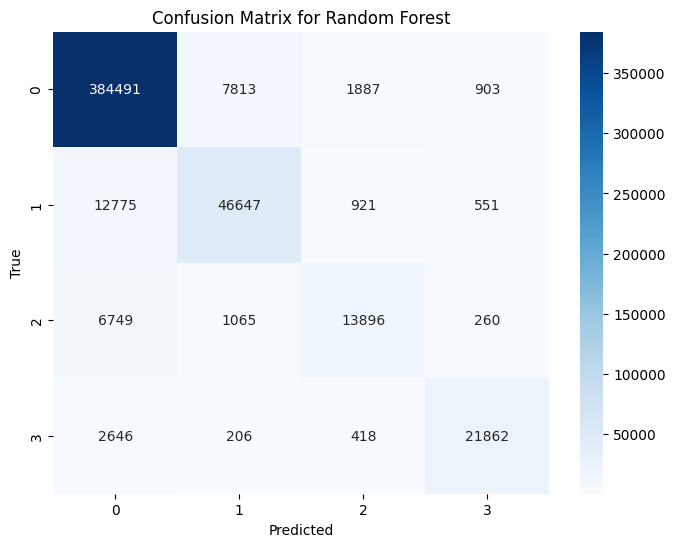

In [7]:


# -----------------------------
# Step 5: Model Evaluation
# -----------------------------
print("\nStep 5: Model Evaluation")
# For demonstration, we use the best model (assumed here as Random Forest based on accuracy)
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
best_model = results[best_model_name]['model']
print(f"Selected best model: {best_model_name}")

# Generate and display confusion matrix for the best model
y_best_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_best_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix for {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [8]:

# -----------------------------
# Step 6: Prediction
# -----------------------------
print("\nStep 6: Prediction")
# Example: Classify a new complaint narrative
sample_text = ("I was unfairly charged on my credit card and my report was negatively affected. "
               "I need assistance with credit repair.")
print("Original sample complaint narrative:")
print(sample_text)

# Preprocess the sample text using the same preprocessing function
sample_clean = preprocess_text(sample_text)
sample_vector = tfidf.transform([sample_clean])
predicted_category = best_model.predict(sample_vector)[0]

print("Predicted category for the sample complaint:")
print(predicted_category)


Step 6: Prediction
Original sample complaint narrative:
I was unfairly charged on my credit card and my report was negatively affected. I need assistance with credit repair.
Predicted category for the sample complaint:
0


In [9]:
import joblib

# Save the best model to disk
joblib.dump(best_model, 'best_model.pkl')
print("Best model saved as best_model.pkl")


Best model saved as best_model.pkl


In [10]:
import joblib
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
print("TF-IDF vectorizer saved as tfidf_vectorizer.pkl")


TF-IDF vectorizer saved as tfidf_vectorizer.pkl
